In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
from itertools import islice


from AE_functions import *
from eval_functions import *
from make_dataset import * 

# %matplotlib qt

import warnings
warnings.filterwarnings("ignore")


In [3]:
## Define which training model, that should be evaluated

train = '50896'

In [31]:
## Plotting the reconstructions

no = [0, 0,50, 100, 250, 975] # Change which image, which have to be shown

fig, ax  = plt.subplots(2, 3, figsize=(12, 15))

for i in range(1,6):
    file = f'C:/Users/julie/OneDrive/Skrivebord/Bachelor/JK_bachelor/{train}_training/reconstruction{no[i]}.npy'
    x = np.load(file)

    x.astype(np.float64)

    # Normalize the image, so it fits the float32 format
    x = x[0,:,:]
    img_float32 = (x - np.min(x)) / (np.max(x) - np.min(x))

    ax[i//3, i%3].imshow(img_float32, cmap='gray')
    ax[i//3, i%3].set_title(f'Reconstructed Image, {no[i]} epochs')


file = f'C:/Users/julie/OneDrive/Skrivebord/Bachelor/JK_bachelor/{train}_training/original.npy'
x = np.load(file)
x.astype(np.float64)
x = x[0,:,:]
img_float32 = (x - np.min(x)) / (np.max(x) - np.min(x))

ax[0,0].imshow(img_float32, cmap='gray')
ax[0,0].set_title('Original Image')


fig.show()

fig.savefig(f'C:/Users/julie/OneDrive/Skrivebord/merged_{train}.png')  # Save the plot as a PNG file

In [8]:
## Plotting losses from training

file_loss = f'C:/Users/julie/OneDrive/Skrivebord/Bachelor/JK_bachelor/{train}_training/o_loss.npy'
file_val_loss = f'C:/Users/julie/OneDrive/Skrivebord/Bachelor/JK_bachelor/{train}_training/Val_loss.npy'

o_loss = np.load(file_loss)
val_loss = np.load(file_val_loss)
print(f"Converged towards {np.mean(o_loss[250:])}")

fig, ax = plt.subplots()
ax.set_title(f'Model Loss, batch_size=100, lr=0.001, wd=0.0005')
ax.set_xlabel('Epoch')
ax.set_ylabel('Avg. loss')
ax.set_xticks(np.arange(0, len(o_loss), step= 100))
# ax.set_xticks(np.arange(0, len(o_loss), step= 200))

ax.plot(list(range(1, len(o_loss)+1, 1)), o_loss, label='Training loss', color='b')  # Update the plot with the current loss
ax.plot(list(range(25, len(o_loss)+1, 25)), val_loss, label='Validation loss', color='r')

ax.legend()
plt.show()
# fig.savefig(f'C:/Users/julie/OneDrive/Skrivebord/model_loss_{train}.png')  # Save the plot as a PNG file

Converged towards 0.0007164782436482263


_____________________________

In [4]:
## Loading test image + outlier image

# Loading data (testset, 41 elements)
img_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/img"
heatmap_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/heatmaps"
msk_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/msk"

VerSe_test = LoadData(img_dir=img_dir_test, msk_dir = msk_dir_test, distfield_dir=heatmap_dir_test)
test_loader = DataLoader(VerSe_test, batch_size=1, shuffle=False, num_workers=0)

healthy, outlier = healthy_outlier(test_loader)

# Create datasets
dataset_healthy = generate_dataset(healthy, 120)
dataset_outlier = generate_dataset_outlier(outlier, 120, radius=25)


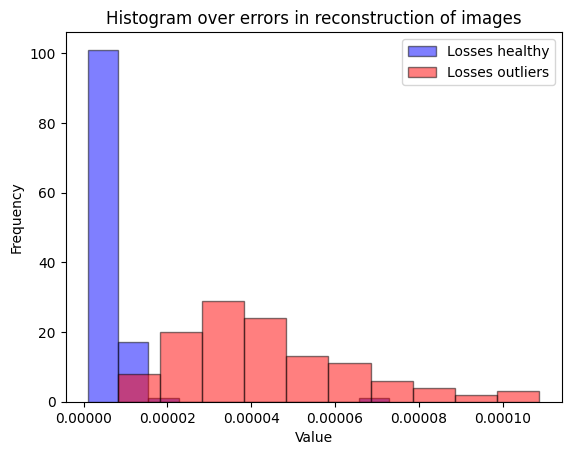

In [5]:
## Evaluating the model with new data (healthy and outliers)

# Loading the model
model_path = f'G:/Mit drev/Uni/6. semester/JK_bachelor/{train}_training/model_conv_999.pth'

model = load_model(model_path, [1, 32, 16, 8])

# Testing the model
error_healthy = []
error_outlier = []

for i in range(len(dataset_healthy)):
    # test_healthy, _, _  = test_loader.dataset[i]
    test_healthy = dataset_healthy[i]
    loss = evaluate_model(model, test_healthy[0].unsqueeze(dim=0))
    error_healthy.append(loss)

    # test_outlier, _, _ = test_loader_o.dataset[i]
    test_outlier = dataset_outlier[i]
    loss = evaluate_model(model, test_outlier[0].unsqueeze(dim=0))
    error_outlier.append(loss)


hist_values1, hist_values2, bins1, bins2 = plot_histograms(error_healthy, error_outlier, 10)

mean_healthy = np.mean(error_healthy)
std_healthy = np.std(error_healthy)

mean_outlier = np.mean(error_outlier)
std_outlier = np.std(error_outlier)

In [6]:
print(f"Mean healthy: {mean_healthy}, std healthy: {std_healthy}")
print(f"Mean outlier: {mean_outlier}, std outlier: {std_outlier}")

Mean healthy: 5.440633298311089e-06, std healthy: 6.937050078647588e-06
Mean outlier: 4.283207074422535e-05, std outlier: 2.0426602999057984e-05


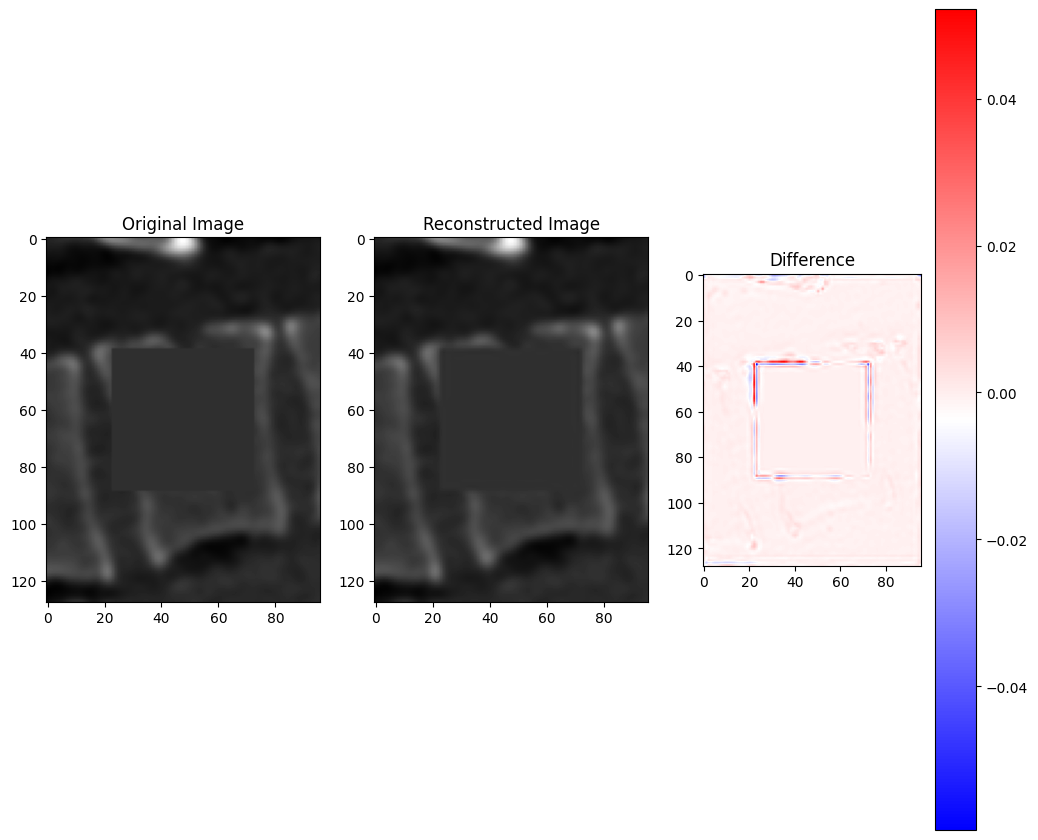

In [7]:
## Plotting the difference from outlier input to reconstructions
org_img = dataset_outlier[0].squeeze()
reconstructed_img = model(dataset_outlier[0].unsqueeze(dim=0)).squeeze().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 15))

ax[0].imshow(dataset_outlier[0].squeeze(), cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(reconstructed_img, cmap='gray')
ax[1].set_title('Reconstructed Image')

ax[2].imshow(org_img - reconstructed_img, cmap='bwr')
ax[2].set_title('Difference')
fig.colorbar(ax[2].imshow(org_img - reconstructed_img, cmap='bwr'))

plt.show()
